This notebook studies the conclusions of:

https://link.springer.com/content/pdf/10.1007%2Fs10994-007-5011-0.pdf

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, brier_score_loss
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [13]:
X, y = make_classification(n_samples=10000, n_features=8, n_informative=6, n_redundant=2, random_state=1)
X_fit, X_test, y_fit, y_test = train_test_split(X, y, test_size=0.3, random_state=1)

In [24]:
model = RandomForestClassifier(random_state=2, max_depth=2)

In [25]:
model.fit(X_fit, y_fit)

RandomForestClassifier(max_depth=2, random_state=2)

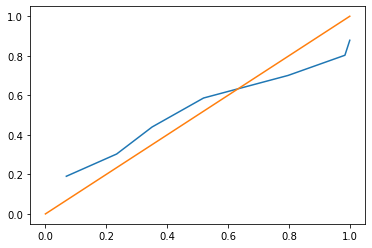

In [32]:
true, pred = calibration_curve(y_fit, model.predict_proba(X_fit)[:,1], n_bins=8)
plt.plot(true, pred)
plt.plot([0,1])

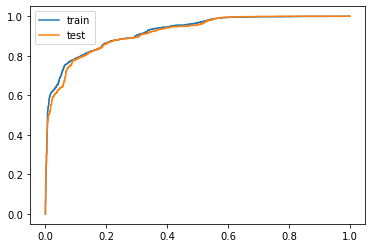

In [26]:
fpr, tpr, _ = roc_curve(y_fit, model.predict_proba(X_fit)[:,1])
plt.plot(fpr, tpr, label='train')

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='test')
plt.legend()
plt.show()

In [27]:
calib = CalibratedClassifierCV(model, cv='prefit', method='isotonic')
calib.fit(X_test, y_test)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(max_depth=2,
                                                             random_state=2),
                       cv='prefit', method='isotonic')

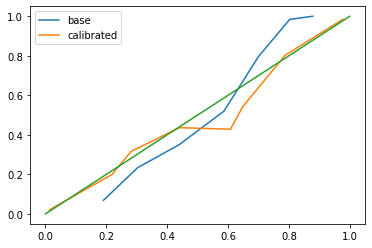

In [34]:
true, pred = calibration_curve(y_fit, model.predict_proba(X_fit)[:,1], n_bins=8)
plt.plot(pred, true, label='base')

true, pred = calibration_curve(y_fit, calib.predict_proba(X_fit)[:,1], n_bins=8)
plt.plot(pred, true, label='calibrated')

plt.plot([0,1])
plt.legend()
plt.show()

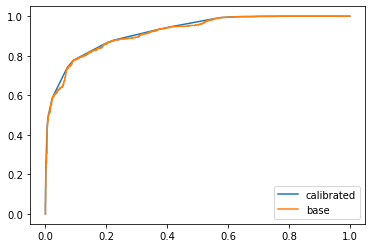

In [28]:
fpr, tpr, _ = roc_curve(y_test, calib.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='calibrated')

fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.plot(fpr, tpr, label='base')


plt.legend()
plt.show()

In [36]:
roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

0.9180108190094147

In [35]:
roc_auc_score(y_test, calib.predict_proba(X_test)[:,1])

0.9225963844469072

As we can see, this indeed introduces a convex hull.

## But isn't the calibration curve monotonic? It should not change the AUC!

This was also pointed out in this issue:

https://github.com/scikit-learn/scikit-learn/issues/16321

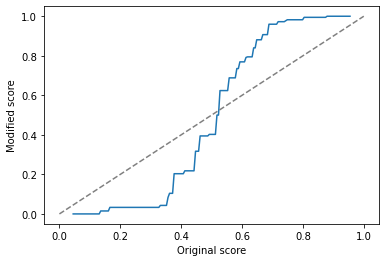

In [75]:
calibrator = calib.calibrated_classifiers_[0].calibrators[0]

x = np.linspace(0,1, num=200)
plt.plot(x, calibrator.f_(x))
plt.plot([0,1], linestyle='--', color='gray')
plt.xlabel("Original score")
plt.ylabel("Modified score")
plt.show()

This curve is stepwise constant. This causes points to collide (since it is not injective) and hence changes ranking-based metrics such as the AUC.

This issue https://github.com/scikit-learn/scikit-learn/pull/21454 discusses using **centered** isotonic regression instead of piecewise. This is a great improvement since it makes the curve injective.